#Task 1 - Load and Prepare the Oxford-IIIT Pets Dataset [5 Marks]

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

trainset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True)
testset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True)

100%|██████████| 791918971/791918971 [00:31<00:00, 24950590.88it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10740994.41it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [2]:
# Access the first sample to check its shape
image, label = trainset[0]
print(image.size)

print(f"Label: {label}")

(394, 500)
Label: 0


In [3]:
classes = trainset.classes

# Print class names
print("Class labels and their corresponding names:")
for idx, class_name in enumerate(classes):
  print(f"Label {idx}: {class_name}")

Class labels and their corresponding names:
Label 0: Abyssinian
Label 1: American Bulldog
Label 2: American Pit Bull Terrier
Label 3: Basset Hound
Label 4: Beagle
Label 5: Bengal
Label 6: Birman
Label 7: Bombay
Label 8: Boxer
Label 9: British Shorthair
Label 10: Chihuahua
Label 11: Egyptian Mau
Label 12: English Cocker Spaniel
Label 13: English Setter
Label 14: German Shorthaired
Label 15: Great Pyrenees
Label 16: Havanese
Label 17: Japanese Chin
Label 18: Keeshond
Label 19: Leonberger
Label 20: Maine Coon
Label 21: Miniature Pinscher
Label 22: Newfoundland
Label 23: Persian
Label 24: Pomeranian
Label 25: Pug
Label 26: Ragdoll
Label 27: Russian Blue
Label 28: Saint Bernard
Label 29: Samoyed
Label 30: Scottish Terrier
Label 31: Shiba Inu
Label 32: Siamese
Label 33: Sphynx
Label 34: Staffordshire Bull Terrier
Label 35: Wheaten Terrier
Label 36: Yorkshire Terrier


In [4]:
# creating a list of unique labels
unique_labels = list(trainset.class_to_idx.values())
print(unique_labels)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


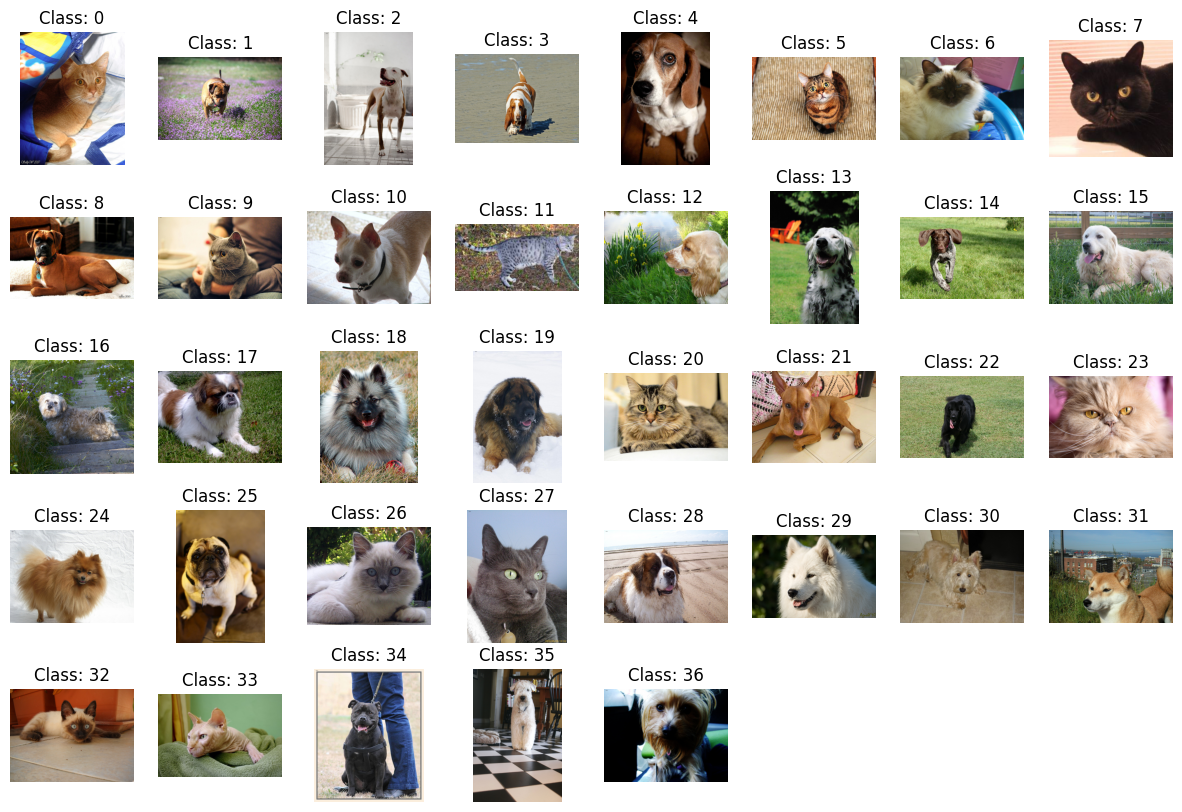

In [5]:
import matplotlib.pyplot as plt
import random

# Create a dictionary to store a randomly picked image for each class
images = {}
for label in unique_labels:
  images[label] = None

# Iterate over the dataset and pick a random image for each class
for image, label in trainset:
  if images[label] is None:
    images[label] = image
  if all(value is not None for value in images.values()):
    break

# Display the images
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
  plt.subplot(5, 8, i + 1)
  plt.imshow(images[label])
  plt.title(f"Class: {label}")
  plt.axis("off")

plt.show()


In [6]:
import torch.nn.functional as F
# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes=37):
  return F.one_hot(labels, num_classes=num_classes).float()

# Create a one-hot encoded version of the dataset
train_labels = torch.tensor([label for _, label in trainset])
train_one_hot_labels = one_hot_encode(train_labels)

In [7]:
# Use torchvision.transforms.Resize to resize all images to 128x128 pixels with bicubic interpolation.
from torchvision.transforms.functional import InterpolationMode
size = (128, 128)
imgtransform = torchvision.transforms.Resize(size, interpolation=InterpolationMode.BILINEAR, max_size=None, antialias=True)
# apply imgtransform on trainset

# Create a new list to store the transformed dataset
transformed_trainset = []
for image, label in trainset:
  transformed_image = imgtransform(image)
  transformed_trainset.append((transformed_image, label))

# Create a new list to store the transformed dataset
transformed_testset = []
for image, label in testset:
  transformed_image = imgtransform(image)
  transformed_testset.append((transformed_image, label))

# Assign the new list to the original variable
trainset = transformed_trainset
testset = transformed_testset

In [8]:
# transform to normalize the images pixel values
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize RGB channels
])

# Apply the transform to each image
# train set
tensor_trainset = []
for image, label in trainset:
  image = transform(image)
  tensor_trainset.append((image, label))
trainset = tensor_trainset

# test set
tensor_testset = []
for image, label in testset:
  image = transform(image)
  tensor_testset.append((image, label))
testset = tensor_testset


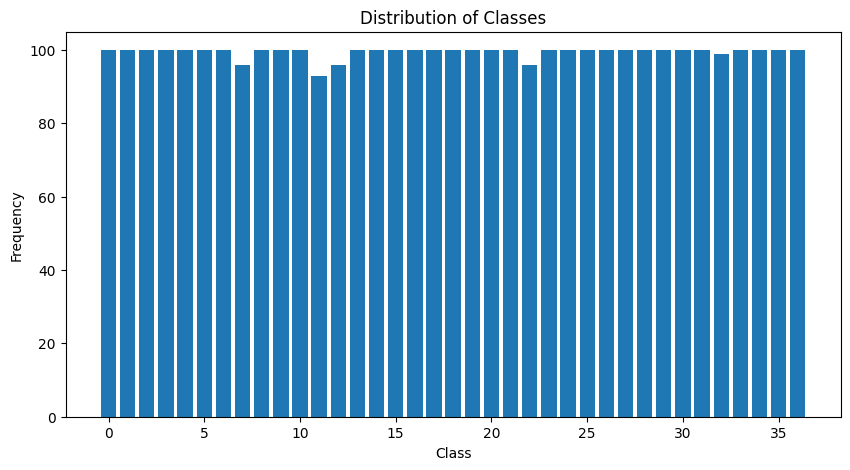

In [9]:
# get the labels from trainset
labels = [label for _, label in tensor_trainset]

# calculate the frequency of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Distribution of Classes")
plt.show()

# Task 2 - Data Splitting [1 Marks]

In [10]:
# split the trainset into valset and trainset
lengths = [int(len(trainset)*0.80), len(trainset) - int(len(trainset)*0.80)]
trainset, valset = torch.utils.data.random_split(trainset, lengths)

print(len(trainset))
print(len(valset))

2944
736


In [11]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=True)


In [12]:
# Check if DataLoaders are working
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(len(train_loader), len(val_loader))

46 12


#Task 3 -  Design a CNN Model [7 Marks]

Model Architecture
Define Layers: Design a CNN with a suitable number of convolutional layers, MaxPooling layers, and fully connected layers. Adjust Filters: Choose appropriate numbers of filters and kernel sizes for each convolutional layer

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    # 4 convolution layers are defined as follows
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    # dropout rate is kept 0.6 for better generalizability of the model
    self.dropout = nn.Dropout(0.6)

    self.fc1 = nn.Linear(128 * 32 * 32, 128)  # Adjust input features based on image size
    self.fc2 = nn.Linear(128, 37)

  def forward(self, x):

    x = F.relu(self.conv1(x))

    x = F.relu(self.conv2(x))

    x = self.maxpool(x)

    x = F.relu(self.conv3(x))

    x = F.relu(self.conv4(x))

    x = self.maxpool(x)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))

    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [24]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=9458e1a941c8618fa90336b4be7840d49806faba072109cb5d9edae279c047a5
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


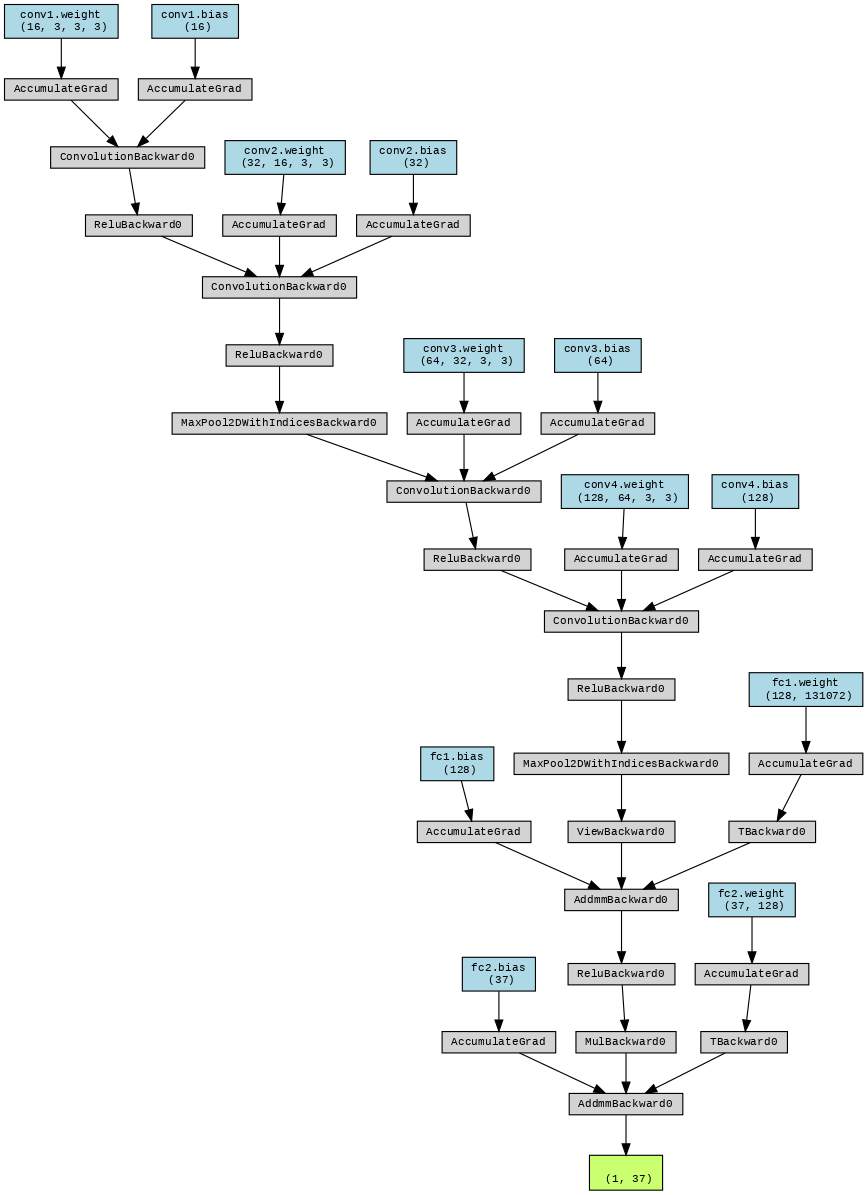

In [28]:
# visualizing SimpleCNN architecture
from IPython.display import Image
from torchviz import make_dot

model = SimpleCNN()
x = torch.randn(1, 3, 128, 128)
y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("simple_nn", format="png")

# show simple_nn.png
Image(filename='simple_nn.png')


# Task 4 -Training the Model [5 Marks]

In [29]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available: ", cuda_available)

CUDA Available:  True


In [30]:
# Instantiate the model
model = SimpleCNN()
print(model)
if cuda_available:
  model.cuda()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


In [31]:
# Define the loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Defining learning rate scheduler
# as mentioned in the question we will be using ReduceLROnPlateau algorithm for scheduling learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [32]:
# Training parameters
num_epochs = 50

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  # Training
  for images, labels in train_loader:
    optimizer.zero_grad()
    if cuda_available:
      images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() # running_loss += loss.item() * images.size(0)

  avg_train_loss = running_loss / len(train_loader) # avg_train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(avg_train_loss)

  # Validation
  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for images, labels in val_loader:
      if cuda_available:
        images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() # val_loss += loss.item() * images.size(0)
  avg_val_loss = val_loss / len(val_loader) # epoch_val_loss = val_loss / len(val_loader.dataset)
  val_losses.append(avg_val_loss)
  scheduler.step(avg_val_loss)
  current_lr = optimizer.param_groups[0]['lr']
  print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Learning Rate: {current_lr:.6f}")

Epoch [1/50], Training Loss: 3.6124, Validation Loss: 3.6136, Learning Rate: 0.010000
Epoch [2/50], Training Loss: 3.6112, Validation Loss: 3.6137, Learning Rate: 0.010000
Epoch [3/50], Training Loss: 3.6102, Validation Loss: 3.6139, Learning Rate: 0.010000
Epoch [4/50], Training Loss: 3.6105, Validation Loss: 3.6131, Learning Rate: 0.010000
Epoch [5/50], Training Loss: 3.6076, Validation Loss: 3.6134, Learning Rate: 0.010000
Epoch [6/50], Training Loss: 3.6055, Validation Loss: 3.6129, Learning Rate: 0.010000
Epoch [7/50], Training Loss: 3.6048, Validation Loss: 3.6103, Learning Rate: 0.010000
Epoch [8/50], Training Loss: 3.6020, Validation Loss: 3.6077, Learning Rate: 0.010000
Epoch [9/50], Training Loss: 3.5970, Validation Loss: 3.6024, Learning Rate: 0.010000
Epoch [10/50], Training Loss: 3.5899, Validation Loss: 3.5918, Learning Rate: 0.010000
Epoch [11/50], Training Loss: 3.5728, Validation Loss: 3.5727, Learning Rate: 0.010000
Epoch [12/50], Training Loss: 3.5483, Validation Los

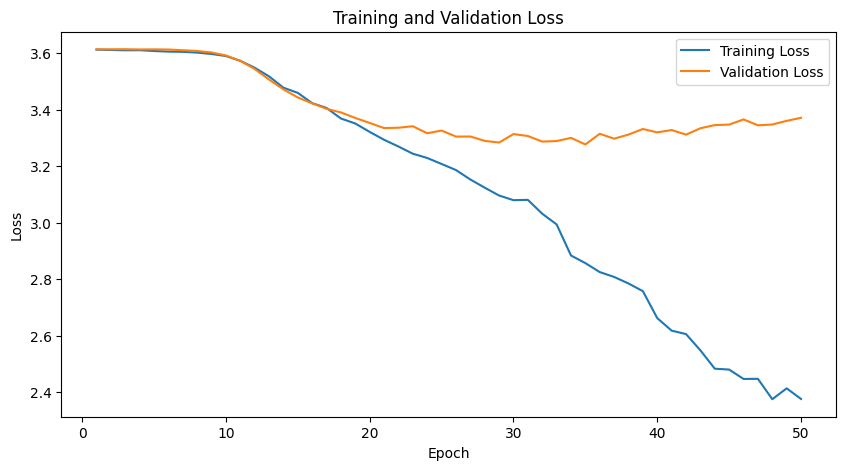

In [33]:
if cuda_available:
 model = model.to('cpu')

# Save the trained model
torch.save(model.state_dict(), 'simple_cnn.pth')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Task 5 - Evaluate the Model [2 Marks]

In [34]:
test_loader = DataLoader(testset, batch_size=1000, shuffle=True)

In [35]:
# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

# iterating over test set
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

<ipython-input-35-acc04e919a31>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('simple_cnn.pth'))


In [37]:
# total accuracy is computed by comparing predictions and true labels
overall_accuracy = 0
for i in range(len(all_preds)):
  if all_preds[i] == all_labels[i]:
    overall_accuracy += 1
overall_accuracy /= len(all_preds)
percentage = overall_accuracy * 100
print('Overall accuracy is : {0:.3f}'.format(percentage))

Overall accuracy is : 9.785


Classification Report:

                            precision    recall  f1-score   support

                Abyssinian       0.05      0.03      0.04        98
          American Bulldog       0.07      0.05      0.06       100
 American Pit Bull Terrier       0.03      0.02      0.02       100
              Basset Hound       0.11      0.13      0.12       100
                    Beagle       0.07      0.05      0.06       100
                    Bengal       0.07      0.01      0.02       100
                    Birman       0.13      0.13      0.13       100
                    Bombay       0.22      0.43      0.30        88
                     Boxer       0.06      0.04      0.05        99
         British Shorthair       0.09      0.06      0.07       100
                 Chihuahua       0.06      0.06      0.06       100
              Egyptian Mau       0.16      0.10      0.12        97
    English Cocker Spaniel       0.02      0.01      0.01       100
            English Set

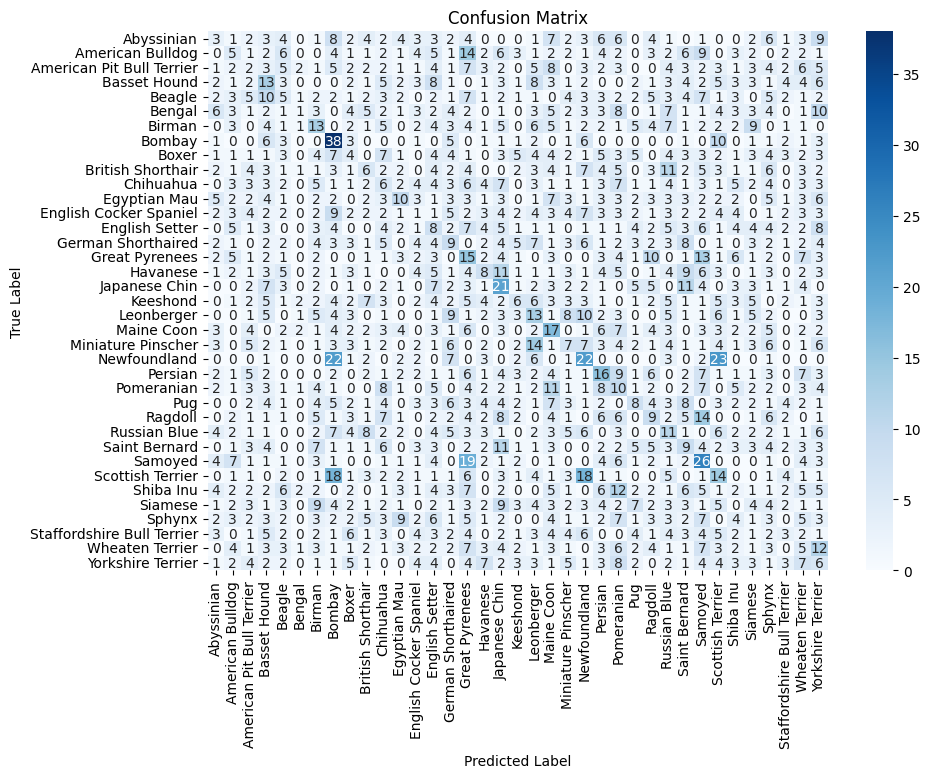

In [38]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()